# File 2/01 of PyTorch learning, 
## Focus: End to End workflow
### Resorces:
* Docs: https://pytorch.org/docs/stable/index.html **(press Table of content v)**
* Book: https://www.learnpytorch.io/00_pytorch_fundamentals/#exercises
* Video: https://www.youtube.com/watch?v=V_xro1bcAuA&t=4749s

In [356]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting everything together"
                      }

In [357]:
import torch as pt
from torch import nn # nn contains all of pytorchs building blocks neural networks
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

Data can be almost anything in ml
* Excel sheet
* images of any kind
* Videos (yt ex)
* Audio like songs or podcast
* DNA
* Text

ML is 2 parts:
1. Get data to numerical representation
2. Build a model to learn the patterns from the numbers


To showcase this, let's create some known data using the linear regression formula

We will use lrf to make a straight line from known parameters

In [358]:
# Creating known paramters
weight = 2 # k from y = kX+m
bias = 1 # m


# Create data
X = pt.linspace(0, 1, 50).unsqueeze(dim=1)
y = bias*X + weight
 

# The three datasets
1. Training set (tränande tester), can be about 70% of data
2. Validation set (tränande tester), maybe 15%
3. test set (testa om den funkar, sista testet), and then 15%

procenterna kan bli sett som i skolan där de olika värdena representerar olika tester och lektioner
1. training set kan ses som varje lektion där man får uppgifter
2. Validation set som prov genom terminen i ex matte/fysik/kemi
3. test set som Slutprov/Nationella

In [359]:
# Create a train/test split
train_split = int(0.8*len(X)) # 1 2 3 4 5 6 7 8 : 9 10
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test =  X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

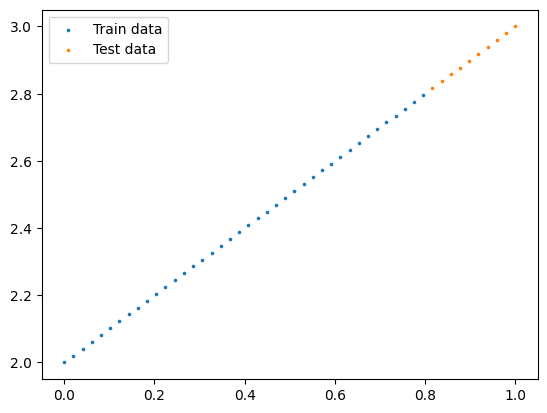

In [360]:
# Sökes: en model där de oranga plupparna täcks av ml valda pluppar
def plot_predictions(train_data=X_train, train_label=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  if predictions is not None:
    plt.scatter(X_test, predictions, label="Train data",s=4)
  plt.scatter(train_data, train_label, label="Train data",s=2.5)
  plt.scatter(test_data, test_labels, label = "Test data",s=2.5)
  plt.legend()
  plt.show()


plot_predictions(X_train, y_train, X_test, y_test, None)

## 2. Build model
#Our first PyTorch model
#This is soooo exciting!!

### Classes info (OOP) in Real Python: https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight, bias)
* Look at training and adjust the random values to better represent the ideal values (the weight and bias we used to create the data)

How to do:
Through two main algorithms:
1. Gradient descent: https://shorturl.at/rtLT3
2. Back propogation: https://tinyurl.com/2af8m886

In [361]:

# Create a linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()

    # skapar alla variablar
    # ex i lager eller som i denna med enstaka värden

    # starta med random nummer på dessa, titta på datan och sedan updatera dessa för att få en som ger rätt svar
    self.weights = nn.Parameter(pt.randn(1,
                                         requires_grad = True, # needed for gradient descend
                                         dtype=pt.float))
    self.bias = nn.Parameter(pt.randn(1, 
                                     requires_grad = True,
                                     dtype=pt.float))
  # forward method defines the computations in the model
  def forward(self, x: pt.Tensor) -> pt. Tensor: # <- "x" is the input data:
    return self.weights * x + self.bias # kx+m


In [362]:
# Create a random seed
pt.manual_seed(42)
# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [363]:
# List named paramters
model_0.state_dict() # we want these as close to chosen weights and biases as possible

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()
To check our model's  predictive power, let's see how well it predicts 'y_test' basted on 'X_test'

When data is passed through our model, its going to run it through our forward() model

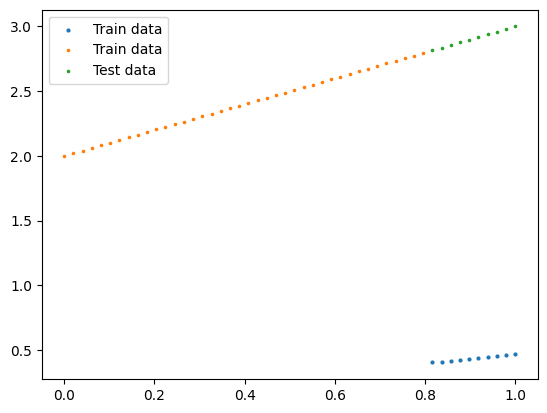

In [364]:
# Make predictions with model
with pt.inference_mode(): # hjälper med predictions, tar bort gradient tracking eftersom den inte behövs
# i sin tur gör det fördelen att det går mycket fortare vid större datasets 
  y_preds = model_0(X_test) # att kalla klassen som vi gör här orsakar användning av forward 

# annan metod och gör liknande ting, men inference mode är föredraget
# with pt.no_grad():
#   y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)


## 3. Train model

The whole idea of training is for a model to move from some *unknown* paramters (these may be random) to some known values

Or in other words from a poor representation of data to a better representation of the data

To measure how poorly the models predictions are you need a loss function

* Note: Loss function may also be called cost function, even if their real function are slightly different

Things we need to train:

- **Loss function:** A function that measure how bad the predictions are 
- **Optimizer:** Takes in the account the loss from the loss function and adjust the parameters accordingly (e.g weight and biases)
  - Inside the optimizer you need to set two values
    - params for parameters which you want to update to improve the nn
    - lr for learn rate, defines how big each step to change the paramteres should be

For PyTorch we need:
* A training loop
* A testing loop

In [365]:
# Setting up a loss function
loss_fn = nn.L1Loss() # calculates the MAE or Mean absolute error, alltså medelavståndet mellan önskade och givda

#Setting up an optimizer (stochastic gradient descent)
optimizer = pt.optim.SGD(params=model_0.parameters(), lr=0.01)



### Building a training loop and a testing loop in PyTorch
A couple of things we need in a training loop:
1. Loop through the data
2. Forward pass (this involves data moving through our model's forward() function/s) to make predictions on the data, often also called forward propagation
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each of the parameters in respect to the loss (**back propogation**)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**), gradient = k value 

In [366]:
# An epoch is one loop through the data...
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []


### Training
for epoch in range(epochs): # iterate in a training loop
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that requires gradifent to true

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. calculate loss, comparing predictions with true values
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad, because the gradients accumulate and stack it needs to be turned to zero,
  # simular to a loop with an internal value that has to be reset each time the loop is rerun
  optimizer.zero_grad()

  # 4. Perform backpropogation on the loss, basically go back into the parameters and increase the values which pointed to the correct output, but decrease the once that pointed to the false output  
  loss.backward()

  # 5. Step the optimizer (perform gradient descent) always after loss backward
  optimizer.step()

  model_0.eval() # turns off gradient tracking and other settings which the model doesn't need for testing
  if epoch%10 == 0:

    with pt.inference_mode(): #
      # 1. Do the forward pass
      test_pred = model_0(X_test)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test)
      print(f"Epoch: {epoch}, Loss: {loss}, Test loss: {test_loss}")
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)


Epoch: 0, Loss: 2.1351606845855713, Test loss: 2.459969997406006
Epoch: 10, Loss: 2.0193233489990234, Test loss: 2.323828935623169
Epoch: 20, Loss: 1.9034866094589233, Test loss: 2.187687635421753
Epoch: 30, Loss: 1.787649393081665, Test loss: 2.051546335220337
Epoch: 40, Loss: 1.6718122959136963, Test loss: 1.915405511856079
Epoch: 50, Loss: 1.555975317955017, Test loss: 1.7792644500732422
Epoch: 60, Loss: 1.4401382207870483, Test loss: 1.6431238651275635
Epoch: 70, Loss: 1.3243013620376587, Test loss: 1.5069828033447266
Epoch: 80, Loss: 1.2084643840789795, Test loss: 1.3708418607711792
Epoch: 90, Loss: 1.0926275253295898, Test loss: 1.2347009181976318
Epoch: 100, Loss: 0.9767906069755554, Test loss: 1.0985602140426636
Epoch: 110, Loss: 0.8609535098075867, Test loss: 0.962419331073761
Epoch: 120, Loss: 0.7451167106628418, Test loss: 0.826278567314148
Epoch: 130, Loss: 0.6292796730995178, Test loss: 0.6901376843452454
Epoch: 140, Loss: 0.5134426951408386, Test loss: 0.5539968609809875


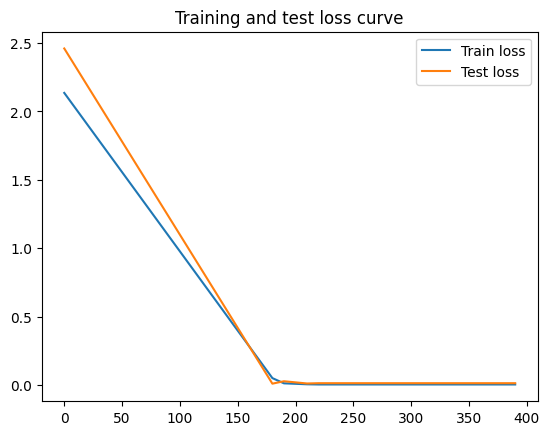

In [367]:
with pt.inference_mode():
    plt.plot(epoch_count, loss_values, label="Train loss")
    plt.plot(epoch_count, test_loss_values, label="Test loss")
    plt.title("Training and test loss curve")
    plt.legend()
    plt.show

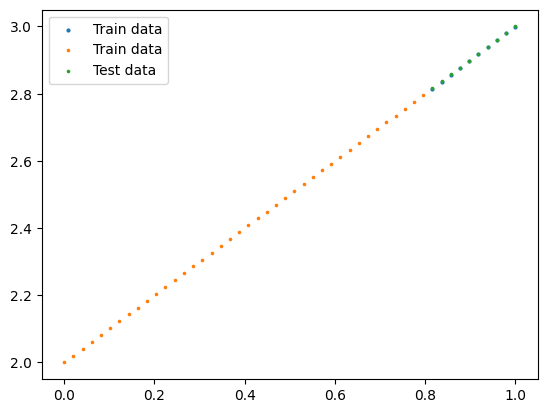

In [368]:
with pt.inference_mode():
  y_preds_new = model_0(X_test)
  plot_predictions(predictions = y_preds_new)

In [369]:
model_0.state_dict()

OrderedDict([('weights', tensor([1.0055])), ('bias', tensor([1.9943]))])

## Saving a model in PyTorch 
There are three main methods you should know about for saving and loading models in PyTorch

1. pt.save() - allows you to savea PyTorch object in Pythons pickle format
2. torch.load() - allows you to load a saved PyTorch object
3. torch.nn.Module.load_state_dict() - this allows you to load a models saved state dictionary, which are the most important parameters

# can be done by saving the state dict or the entire model

[Parameter containing:
 tensor([1.0055], requires_grad=True),
 Parameter containing:
 tensor([1.9943], requires_grad=True)]